In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


## Read the Dataset

In [2]:
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=url, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

## Mari kita liat sekilas datanya, untuk melihat data ini tentang apa

In [3]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


**Dataset ini adalah data cuaca setiap jam**, dari suhu (T °C), tekanan udara, kelembapan relatif, titik embun, kecepatan angin, dll yang diambil di stasiun meteorologi Jena antara tahun 2009 hingga 2016. Karena setiap observasi merupakan data **time series**, data temporalnya sangat cocok untuk diolah dengan **model RNN**. Nantinya, kita akan menggunakan **beberapa jam data historis sebagai input** untuk **memprediksi nilai suhu pada jam berikutnya** untuk **menangkap pola waktu**.


## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


Sekilas, **tidak ada data yang hilang**, data juga sudah dalam bentuk **float untuk semua data numerik**, namun variable **Date Time** nantinya **diparsing menjadi datetime per jam** untuk **membuat pola musiman**.


### Cek Missing Value

In [6]:
df.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

Tidak ada data yang missing

### Cek Data Duplikat

In [7]:
df.duplicated().sum()

327

Ada beberapa data yang duplikat

### Parsing data DateTime

In [8]:
# Parse datetime and set index
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [9]:
# Resample to hourly average
df_hourly = df.resample('1h', on='Date Time').mean().reset_index()

Karena kasus **forecasting berdasarkan urutan waktu**, saya melakukan **parsing pada datetime**, menjadi **hourly**, lalu **membuat fitur musiman**, dan mengatur data sesuai dengan **urutan waktu asli**.


In [10]:
# Show missing values and duplicates
missing_values = df_hourly.isnull().sum()
duplicates_count = df_hourly.duplicated().sum()

missing_values, duplicates_count

(Date Time           0
 p (mbar)           88
 T (degC)           88
 Tpot (K)           88
 Tdew (degC)        88
 rh (%)             88
 VPmax (mbar)       88
 VPact (mbar)       88
 VPdef (mbar)       88
 sh (g/kg)          88
 H2OC (mmol/mol)    88
 rho (g/m**3)       88
 wv (m/s)           88
 max. wv (m/s)      88
 wd (deg)           88
 dtype: int64,
 0)

Setelah **resample**, terdapat **missing value di semua kolom**, masing-masing sebanyak **88 data**, namun **data duplikat sudah tidak ditemukan**.


### Benarkan data yang hilang dengan Interpolasi Linear

In [11]:
# Setel Date Time sebagai index untuk interpolasi time-series
df_hourly_indexed = df_hourly.set_index("Date Time")

# Lakukan interpolasi linier
df_hourly_interpolated = df_hourly_indexed.interpolate(method='linear')

# Verifikasi bahwa semua missing value telah diatasi
missing_after_interpolation = df_hourly_interpolated.isnull().sum()
missing_after_interpolation

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

**data yang hilang setelah resample** sudah **dibenarkan dengan interpolasi linear**, karena **data bersifat time series**


### Raw Data Visualization

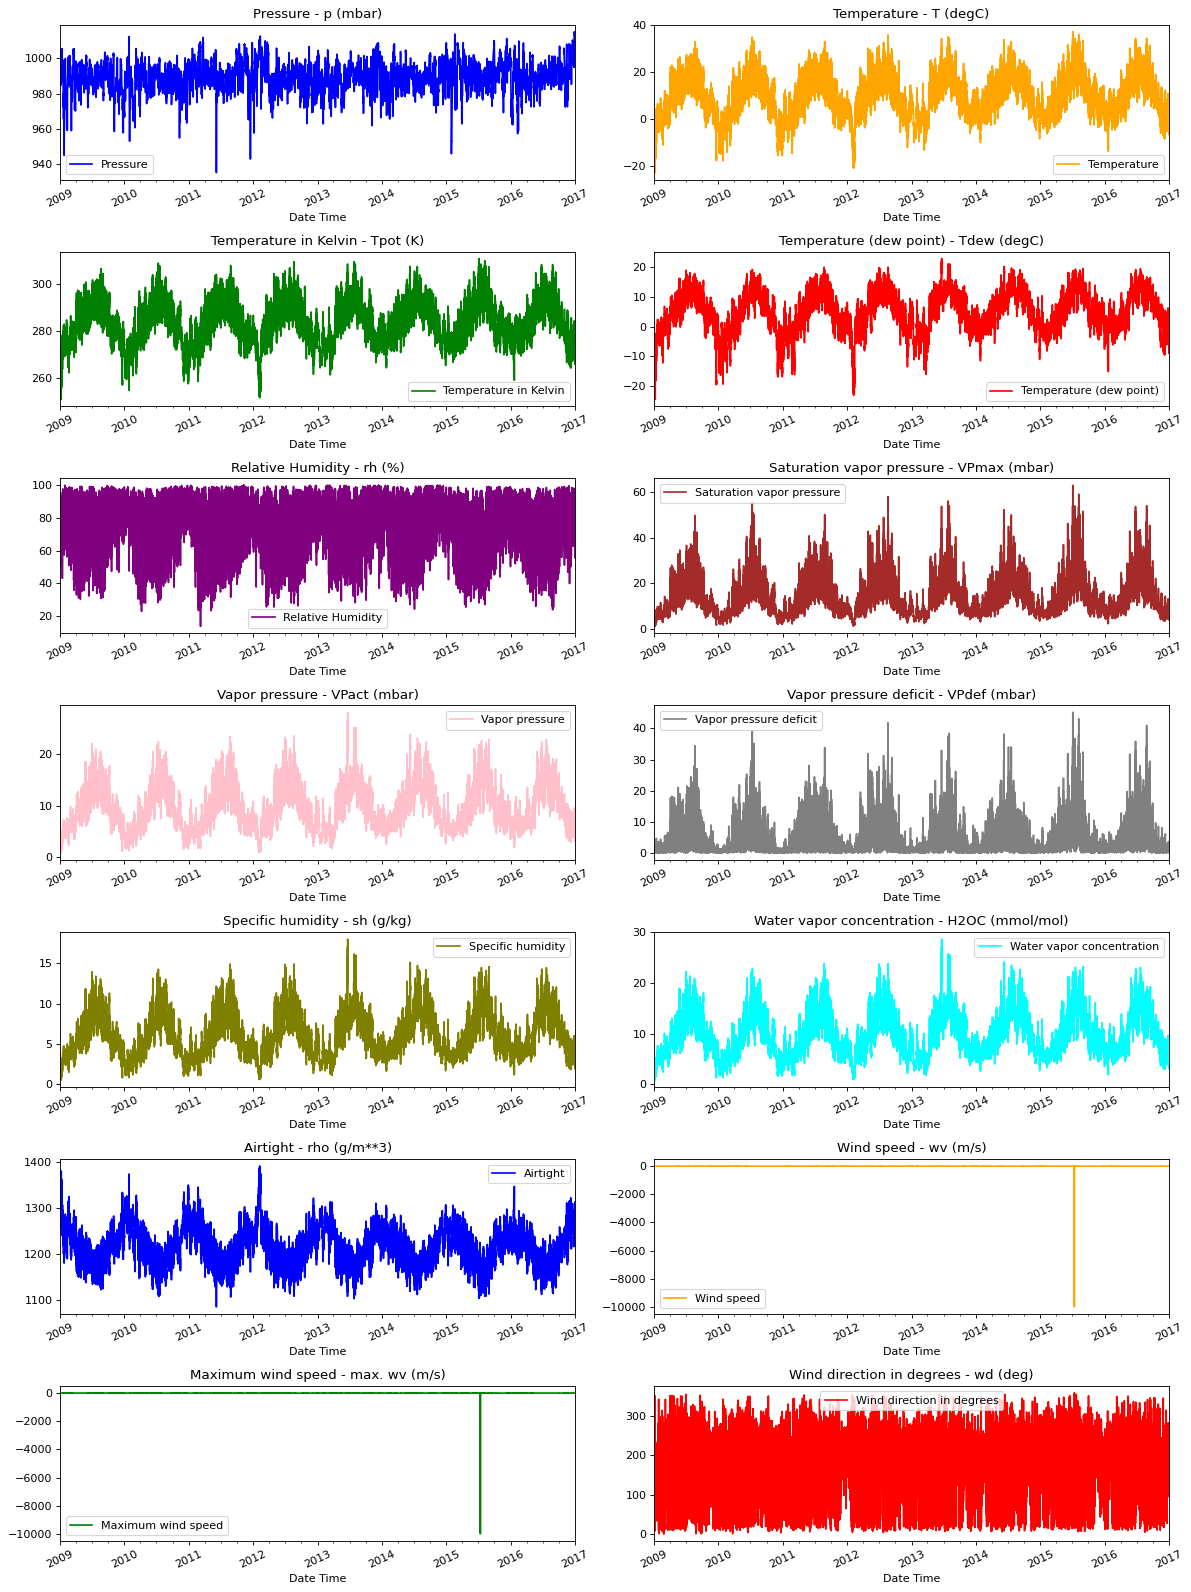

In [12]:
# Visualisasi semua fitur(masih secara mentah)
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"

# Plot
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % len(colors)]
        t_data = data[key]
        t_data.index = time_data
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()
    plt.show()

show_raw_visualization(df_hourly)


Dari visualisasi di atas:

- **Pola musiman sangat kuat** terlihat tiap tahun, kita bisa lihat **suhu sering naik turun secara periodik**, terlihat juga hubungan **T (degC), Tdew, Tpot yang mirip**, normal karena semua sama-sama suhu aktual dan potensial.  
- **Kelembaban dan uap air** yang direpresentasikan dengan `rh`, `VPmax`, `VPact`, `VPdef`, `sh`, dan `H2OC` juga menunjukkan **pola musiman yang jelas**, di mana `rh` tetap tinggi, dan **`VPdef` naik saat kelembaban juga meningkat**.
- **Tekanan (`p (mbar)`)** terlihat memiliki **fluktuasi yang lebih halus dan stabil** dibandingkan dengan suhu.
- `wv` dan `max. wv` memiliki **nilai outlier ekstrem (~ -10000)**, **tidak mungkin terjadi secara fisik**, perlu diperbaiki, mungkin dengan **diimputasi dengan median/interpolasi**.
- `wd` memiliki **distribusi yang beragam dan periodik**, sesuai ekspektasi untuk data arah angin (0–360 derajat).
- **Kerapatan udara (`rho`)** memiliki **pola musiman mirip suhu dan kelembaban** dengan **nilai puncak berbanding terbalik dengan suhu**.
- **Secara keseluruhan**, **tidak ada anomali ekstrem** yang terlihat, tetapi beberapa data seperti `wv`, `max. wv` memiliki **nilai yang tiba-tiba rendah**, namun akan **diperiksa lebih lanjut saat preprocessing**.

### Cek Distribusi Data

In [13]:
def plot_feature_distributions(data):
    data.hist(figsize=(16, 12), bins=50, color='skyblue', edgecolor='black')
    plt.suptitle("Distribusi Fitur", fontsize=20)
    plt.tight_layout()
    plt.show()


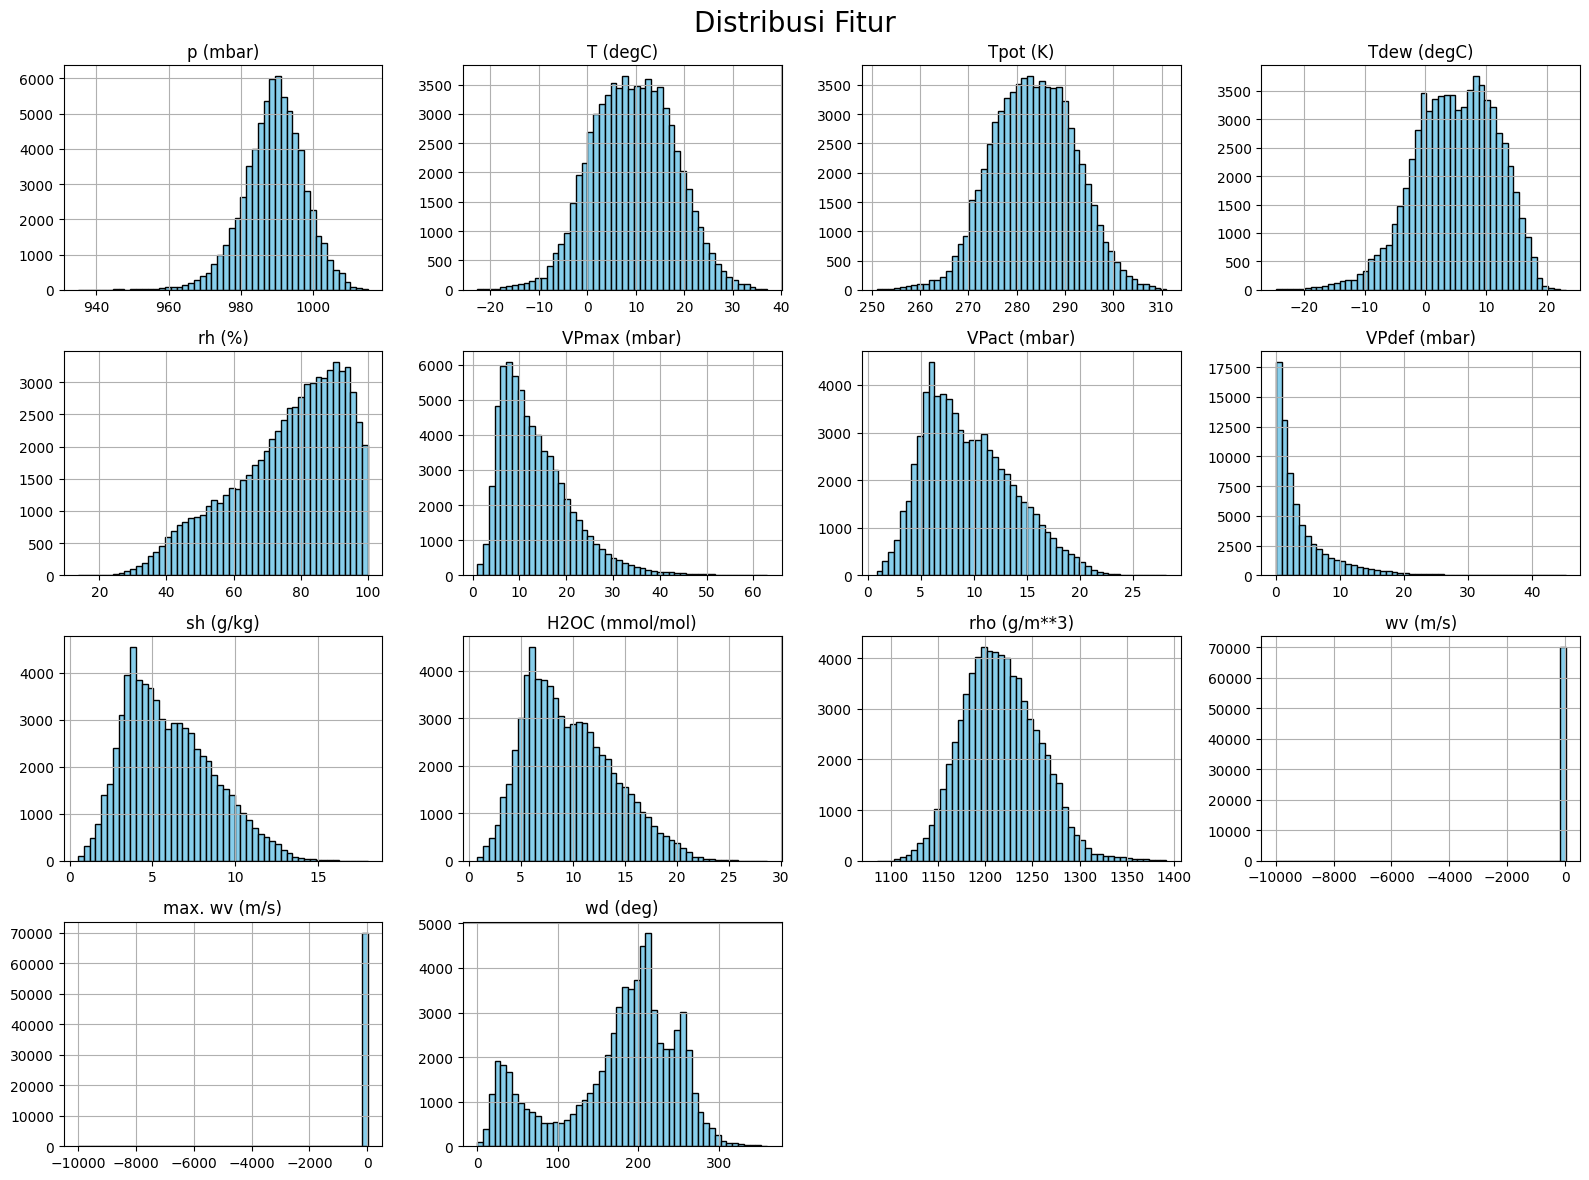

In [14]:
# Jalankan visualisasi
plot_feature_distributions(df_hourly_interpolated)

Distribusi Fitur:
- **Sebagian besar fitur suhu dan tekanan distribusinya normal**`T (degC)`, `Tdew (degC)`, `Tpot (K)`, `rho (g/m**3)`, dan `p (mbar)`bagus ntuk digunakan dalam model prediktif berbasis time-series seperti ini
- **Kelembaban dan uap air** `rh (%)`, `VPmax`, `VPact`, `VPdef`, `sh`, dan `H2OC` menunjukkan **distribusi skewed**. Ini menandakan banyak nilai rendah dengan sedikit nilai tinggi yang ekstrem, mungkin perlu dinormalisasi dan scaling.
- `VPdef (mbar)` memiliki **lonjakan tajam pada nilai rendah**, menandakan **banyak data dengan defisit uap air   yang kecil** 
- **`wv (m/s)` dan `max. wv (m/s)` memiliki outlier ekstrem sekitar -10000**, seperti yang disebutkan sebelumnya, mungkin bisa diimpute dengan **median**/ **interploasi**

## Penganangan Outlier kecepatan angin

In [15]:
wind_features = ["wv (m/s)", "max. wv (m/s)"]

# Tandai sebagai NaN jika nilai < 0 atau > 100
for col in wind_features:
    df_hourly_interpolated[col] = df_hourly_interpolated[col].apply(
        lambda x: x if 0 <= x <= 100 else np.nan
    )

# Imputasi dengan median
for col in wind_features:
    median_val = df_hourly_interpolated[col].median()
    df_hourly_interpolated[col] = df_hourly_interpolated[col].fillna(median_val)

# Verifikasi apakah masih ada NaN
df_hourly_interpolated[wind_features].isnull().sum()

wv (m/s)         0
max. wv (m/s)    0
dtype: int64

**Outlier ekstrem** sudah diubah ke **rentang valid** (biasanya **kecepatan angin berkisar di 0–100 m/s**).


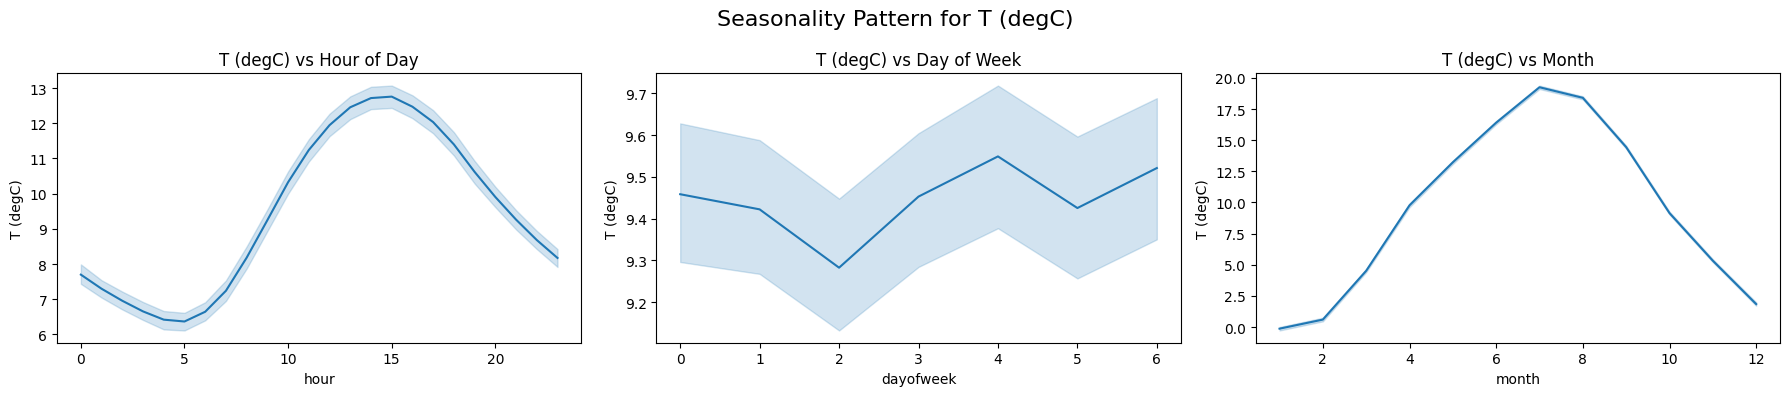

In [16]:
# Tambahkan kolom waktu musiman untuk analisis seasonality
df_seasonal = df_hourly_interpolated.copy()
df_seasonal["hour"] = df_seasonal.index.hour
df_seasonal["dayofweek"] = df_seasonal.index.dayofweek
df_seasonal["month"] = df_seasonal.index.month
df_seasonal["year"] = df_seasonal.index.year

# Plot musiman suhu per jam, hari dalam minggu, dan bulan dalam setahun
def plot_seasonality(data, feature):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    sns.lineplot(data=data, x="hour", y=feature, ax=axes[0])
    axes[0].set_title(f"{feature} vs Hour of Day")
    sns.lineplot(data=data, x="dayofweek", y=feature, ax=axes[1])
    axes[1].set_title(f"{feature} vs Day of Week")
    sns.lineplot(data=data, x="month", y=feature, ax=axes[2])
    axes[2].set_title(f"{feature} vs Month")
    plt.suptitle(f"Seasonality Pattern for {feature}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Tampilkan pola musiman untuk T (degC) sebagai contoh utama
plot_seasonality(df_seasonal, "T (degC)")


## Pola Musiman(Suhu)

- Pola **naik dan turunnya suhu** sesuai dengan **siklus harian matahari**, di mana suhu **rendah pada subuh-subuh**, lalu mulai **memanas dengan puncak di siang hari**, kemudian **menurun kembali saat sore hari**.

- Pola **harian tidak terlalu kuat dalam konteks mingguan**, tetapi ada beberapa variasi, mungkin karena **aktivitas yang berbeda saat weekday dan weekend**.

- Pola **tahunan sangat jelas**, misalnya pada bulan **Januari memiliki suhu terendah**, dan pada **Juli–Agustus merupakan puncak suhu (musim panas)**.



### Feature Encoding

In [17]:
# Tambahkan fitur musiman dalam bentuk sin dan cos
df_seasonal_features = df_hourly_interpolated.copy()
df_seasonal_features["hour_sin"] = np.sin(2 * np.pi * df_seasonal_features.index.hour / 24)
df_seasonal_features["hour_cos"] = np.cos(2 * np.pi * df_seasonal_features.index.hour / 24)
df_seasonal_features["month_sin"] = np.sin(2 * np.pi * df_seasonal_features.index.month / 12)
df_seasonal_features["month_cos"] = np.cos(2 * np.pi * df_seasonal_features.index.month / 12)

# Tampilkan kolom terakhir untuk konfirmasi
df_seasonal_features[["hour_sin", "hour_cos", "month_sin", "month_cos"]].head()


,hour_sin,hour_cos,month_sin,month_cos
Date Time,,,,
2009-01-01 00:00:00,0.000000,1.000000,0.5,0.866025
2009-01-01 01:00:00,0.258819,0.965926,0.5,0.866025
2009-01-01 02:00:00,0.500000,0.866025,0.5,0.866025
2009-01-01 03:00:00,0.707107,0.707107,0.5,0.866025
2009-01-01 04:00:00,0.866025,0.500000,0.5,0.866025


Tambahkan **encoding pada data hour dan month** untuk mendapatkan **pola periodik siklikal** dalam bentuk **kontinu (sin/cos)** supaya bisa **menangkap pola musiman** dengan lebih baik.


## Heatmap(Cek Koreasi Fitur Musiman dan yang asli)

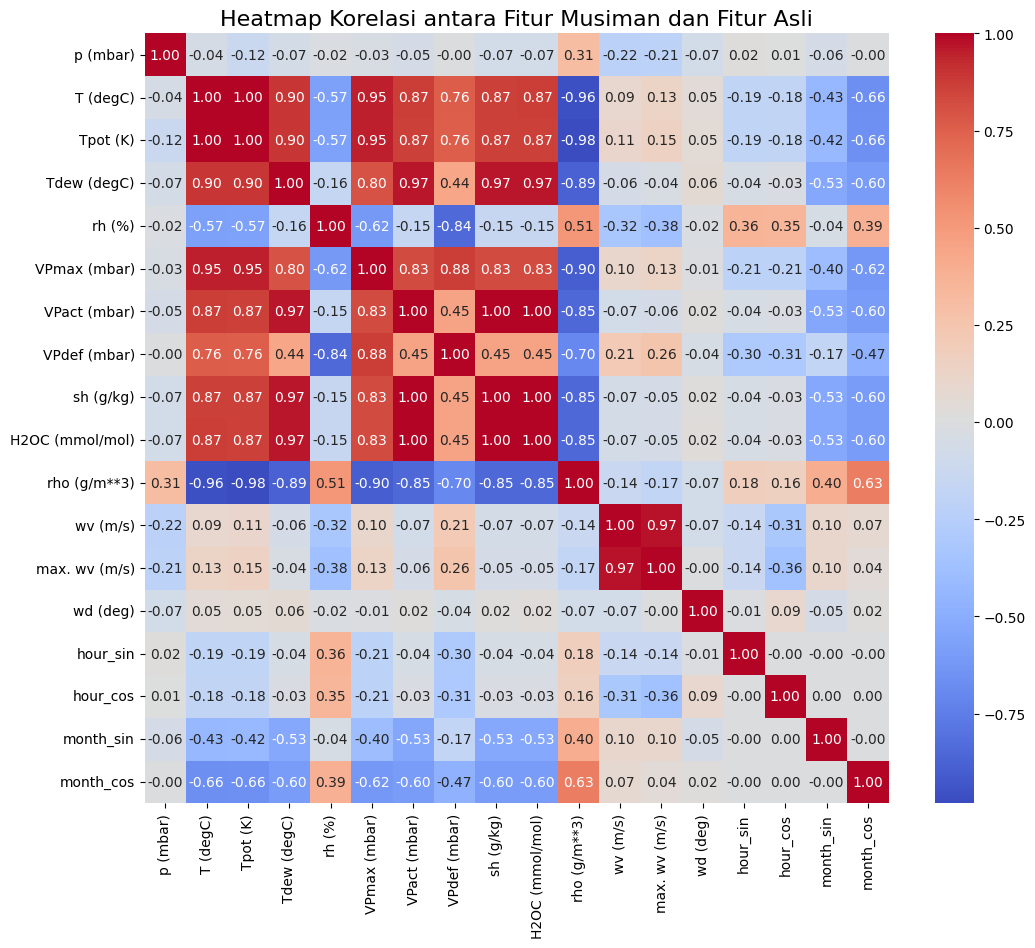

In [18]:
# Tambahkan kolom suhu untuk analisis korelasi dengan fitur musiman
df_corr_check = df_seasonal_features.copy()
df_corr_check["T (degC)"] = df_hourly_interpolated["T (degC)"]

# Hitung korelasi
plt.figure(figsize=(12, 10))
corr = df_corr_check.corr()

# Visualisasi heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap Korelasi antara Fitur Musiman dan Fitur Asli", fontsize=16)
plt.show()

## Korelasi

- **Fitur suhu `T (degC)`** sangat berkorelasi positif dengan:
  - `Tdew`, `Tpot`, `VPact`, `sh`, dan `H2OC` → semuanya berhubungan langsung dengan kelembaban dan energi termal.

- **Fitur musiman `hour_sin` dan `hour_cos`** memiliki korelasi moderat terhadap `T (degC)`:
  - Korelasi ini menunjukkan bahwa **suhu memang bergantung pada waktu dalam sehari**, sesuai dengan siklus matahari.

- **`month_sin` dan `month_cos`** juga menunjukkan korelasi yang cukup kuat terhadap suhu:
  - Ini menegaskan adanya **seasonality tahunan** yang memengaruhi suhu, sesuai dengan ekspektasi cuaca.

- `wd (deg)` (arah angin) memiliki korelasi sangat rendah terhadap hampir semua fitur, termasuk suhu → bisa jadi tidak terlalu relevan.

## Mari kita prediksi suhu menggunakan RNN

### Pertama kita tentukan suhu sebagai target variable kita dan fitur2 nya

In [19]:
# Definisikan target dan fitur
target_col = "T (degC)"
feature_cols = df_seasonal_features.columns.difference([target_col])

# Pisahkan fitur dan target
X = df_seasonal_features[feature_cols]
y = df_hourly_interpolated[target_col]

## Train test split dan normalisasi fitur

In [20]:
# Time Series Split(ukuran split (70% train, 20% val, 10% test))
n = len(X)
train_end = int(n * 0.7)
val_end   = int(n * 0.9)

# Time-based splits
X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val   = X.iloc[train_end:val_end]
y_val   = y.iloc[train_end:val_end]

X_test  = X.iloc[val_end:]
y_test  = y.iloc[val_end:]


Train test split **70%**, **20%**, **10%**, dengan **time series split** karena merupakan data **time series**


In [21]:
# Normalisasi hanya dari training set
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [22]:
# Output shapes for confirmation
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((49090, 17), (14026, 17), (7013, 17))

Saya **normalisasi menggunakan MinMaxScaler** karena **LSTM sangat sensitif terhadap outlier dan skala fitur**, dimana **fungsi aktivasi seperti sigmoid dan tanh** yang bekerja optimal pada input dengan **rentang kecil seperti [0, 1]**.


In [23]:
# Fungsi untuk framing data LSTM (1-step ahead)
def create_lstm_sequences(X, y, window_size=24):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

# Terapkan ke data yang sudah dinormalisasi
window_size = 24

X_train_seq, y_train_seq = create_lstm_sequences(X_train_scaled, y_train_scaled, window_size)
X_val_seq, y_val_seq = create_lstm_sequences(X_val_scaled, y_val_scaled, window_size)
X_test_seq, y_test_seq = create_lstm_sequences(X_test_scaled, y_test_scaled, window_size)

# Output bentuk data
X_train_seq.shape, y_train_seq.shape


((49066, 24, 17), (49066, 1))

Aku menggunakan `window_size = 24` dan 1 step ahead karena **24 jam sebelum akan digunakan untuk memprediksi 1 jam ke depan**.
X_train: `(49004, 24, 17)` → 49.004 sampel, masing-masing 24 jam, 17 fitur
y_train: `(49004, 1)` → target prediksi suhu pada jam ke-25

## RNN MOdel LSTM (Baseline) sebelum dihypertune

In [24]:
model = Sequential([
    ## Untuk menerima sequence 24 jam dengan 17 fitur, lalu dipakai di later LSTM berikutnya
    LSTM(64, return_sequences=True, input_shape=(24, 17)),
    ## pengurangan jumlah unit dari 64 ke 32 untuk mengurangi resiko overfitting
    LSTM(32),
    ## satu neuron linar untuk prediksi suhu(regresi)
    Dense(1)
])

## Adapttif learning rate dan momentum dengan ADAM dengan loss function mse untuk memperbesar penalti untuk outlier, dan mae sebagai metrik yang tahan pada outlier
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

## Kalau tidak ada perubahan signifikan selama 5 epoch, hentikan untuk mencegah overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            20992     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 33,441
Trainable params: 33,441
Non-trainable params: 0
_________________________________________________________________


### Train Model Baseline(Blm Dihypertune)

In [25]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=64,
    callbacks=early_stop,
    verbose=1
)

Epoch 1/20
767/767 [==============================] - 22s 18ms/step - loss: 0.0023 - mae: 0.0286 - val_loss: 4.8127e-04 - val_mae: 0.0168
Epoch 2/20
767/767 [==============================] - 13s 16ms/step - loss: 3.4755e-04 - mae: 0.0141 - val_loss: 2.0658e-04 - val_mae: 0.0106
Epoch 3/20
767/767 [==============================] - 12s 16ms/step - loss: 1.8403e-04 - mae: 0.0101 - val_loss: 1.9621e-04 - val_mae: 0.0112
Epoch 4/20
767/767 [==============================] - 12s 16ms/step - loss: 1.3793e-04 - mae: 0.0087 - val_loss: 1.2886e-04 - val_mae: 0.0083
Epoch 5/20
767/767 [==============================] - 12s 15ms/step - loss: 1.2587e-04 - mae: 0.0082 - val_loss: 1.2198e-04 - val_mae: 0.0083
Epoch 6/20
767/767 [==============================] - 12s 16ms/step - loss: 1.2075e-04 - mae: 0.0080 - val_loss: 9.7489e-05 - val_mae: 0.0069
Epoch 7/20
767/767 [==============================] - 12s 15ms/step - loss: 1.2162e-04 - mae: 0.0081 - val_loss: 9.3553e-05 - val_mae: 0.0067
Epoch 8/20

Kita coba dengan 20 epoch dan 64 batch size sementara








### Evaluasi Model Baseline(Blm Dihypertune)

In [26]:
# Fungsi visualisasi training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
    plt.title("Training vs Validation Loss (MSE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()

    # Plot MAE 
    if 'mae' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Val MAE')
        plt.title("Training vs Validation MAE")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.legend()

    plt.tight_layout()
    plt.show()

In [27]:
# Fungsi evaluasi pada test set
def evaluate_model(model, X_test_seq, y_test_seq, scaler_y):
    y_pred_scaled = model.predict(X_test_seq)
    
    # Balikkan skala ke bentuk asli (inverse transform)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test_seq)

    # Hitung metrik evaluasi
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MSE': mse,
        'R2 Score': r2
    }

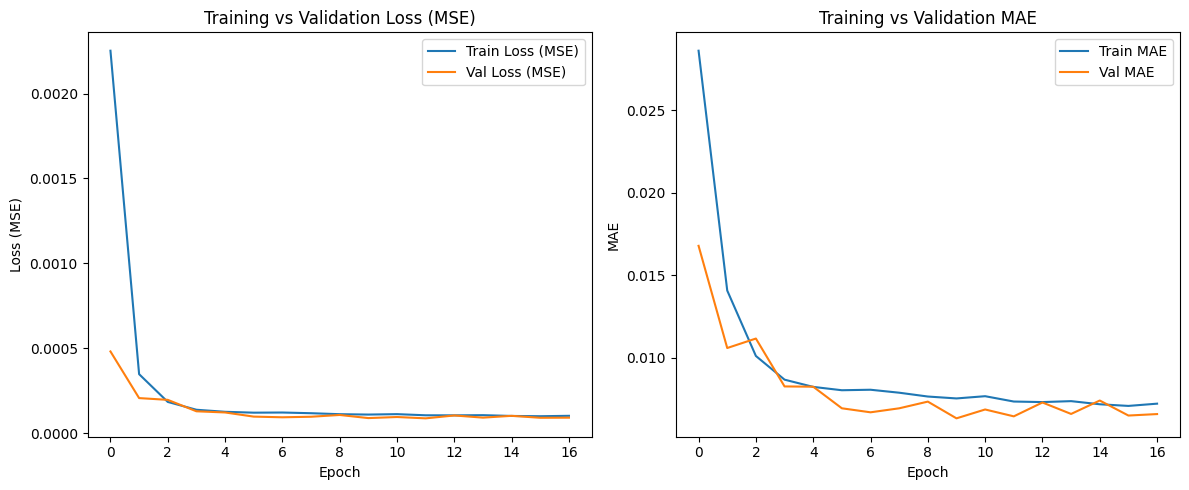

In [28]:
plot_training_history(history)

Pada model baseline ini, terdapat beberapa hal yang **sudah cukup baik**, yaitu:

- **Training loss dan MAE menurun drastis** pada **epoch awal (0–3)** menunjukkan model cukup cepat dalam mempelajari pola dasar.  
- Setelah itu, **kedua metrik mencapai plateau**(Nilai metrik tidak berubah signifikan) dan **gap antara training dan validation sangat kecil**, menandakan **potensi overfitting minim**.  
- **Validation loss dan MAE stabil** setiap epoch, artinya model sudah **cukup generalizable**.  
- Beberapa **fluktuasi kecil di epoch 2–4** wajar untuk data time series dan dapat diatasi dengan **penyetelan learning rate**, penambahan **dropout**, atau **penyesuaian arsitektur**, kita akan coba beberapa di hypertune.

In [29]:
results = evaluate_model(model, X_test_seq, y_test_seq, scaler_y)
print(results)

219/219 [==============================] - 3s 7ms/step
{'MAE': 0.38674356989622616, 'RMSE': 0.5424609994121584, 'MSE': 0.2942639358832377, 'R2 Score': 0.9951102293644012}


## Interpretasi Hasil Evaluasi Model Baseline (belum di-hypertune)

- **MAE → 0.39 °C**  
  Rata-rata prediksi meleset 0.39 °C, artinya model sudah sangat akurat dalam memprediksi suhu.  

- **RMSE → 0.54 °C**  
  Error kuadrat cenderung kecil untuk suhu, masih ada outlier tapi masih dibawah 1 °C. 

- **MSE → 0.29 (°C)**  
  Nilai MSE juga kecil menunjukan distribusi error masih relatif sempit

- **R² Score → 0.9951**  
  Model sudah bisa menjelaskan 99.51% variansi data, yang artinya model sudah sangat bagus



## Hypertuning LSTM

In [30]:
def build_lstm_model(units_1, units_2, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(units_1, return_sequences=True, input_shape=(24, 17)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units_2))
    model.add(Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Hyperparameter grid
param_grid = {
    'units_1':      [64, 128], ## Kita coba eksperimen jumlah neuron pada lapisan pertama
    'units_2':      [32, 64], ## Kita coba eksperimen jumlah neuron pada lapisan kedia
    'dropout_rate': [0.1, 0.2], ## kita coba tambahkan penalti unruk melihat apakah membantu mengurangi overfitting
    'learning_rate':[0.001, 0.0005] ## kita coba menurunkan learning rate untuk menstabilkan kovergensi
}

bs = 64

results = []

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            20992     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 33,441
Trainable params: 33,441
Non-trainable params: 0
_________________________________________________________________


## Train Model LSTM(Hypertune)

In [32]:
for u1 in param_grid['units_1']:
    for u2 in param_grid['units_2']:
        for dr in param_grid['dropout_rate']:
            for lr in param_grid['learning_rate']:
                    print(f"Training: units_1={u1}, units_2={u2}, dropout={dr}, lr={lr}, batch_size={bs}")
                    model = build_lstm_model(u1, u2, dr, lr)
                    history = model.fit(
                        X_train_seq, y_train_seq,
                        validation_data=(X_val_seq, y_val_seq),
                        epochs=20,
                        batch_size= bs,
                        verbose=1,
                        callbacks=[
                            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                        ]
                    )
                    val_loss, val_mae = model.evaluate(X_val_seq, y_val_seq, verbose=0)
                    results.append({
                        'units_1': u1,
                        'units_2': u2,
                        'dropout_rate': dr,
                        'learning_rate': lr,
                        'batch_size': bs,
                        'val_loss': val_loss,
                        'val_mae': val_mae
                    })

Training: units_1=64, units_2=32, dropout=0.1, lr=0.001, batch_size=64
Epoch 1/20
767/767 [==============================] - 17s 18ms/step - loss: 0.0039 - mae: 0.0347 - val_loss: 5.1452e-04 - val_mae: 0.0173
Epoch 2/20
767/767 [==============================] - 13s 16ms/step - loss: 5.4111e-04 - mae: 0.0178 - val_loss: 2.4027e-04 - val_mae: 0.0115
Epoch 3/20
767/767 [==============================] - 13s 16ms/step - loss: 3.2089e-04 - mae: 0.0136 - val_loss: 1.6718e-04 - val_mae: 0.0095
Epoch 4/20
767/767 [==============================] - 13s 17ms/step - loss: 2.5292e-04 - mae: 0.0120 - val_loss: 1.3684e-04 - val_mae: 0.0085
Epoch 5/20
767/767 [==============================] - 12s 16ms/step - loss: 2.1462e-04 - mae: 0.0110 - val_loss: 1.2385e-04 - val_mae: 0.0080
Epoch 6/20
767/767 [==============================] - 13s 17ms/step - loss: 1.9612e-04 - mae: 0.0105 - val_loss: 1.3532e-04 - val_mae: 0.0087
Epoch 7/20
767/767 [==============================] - 13s 17ms/step - loss: 1.780

In [33]:
# Simpan hasil ke DataFrame
results_df = pd.DataFrame(results).sort_values(by='val_loss')

In [34]:
print(results_df)

    units_1  units_2  dropout_rate  learning_rate  batch_size  val_loss  \
0        64       32           0.1         0.0010          64  0.000092   
15      128       64           0.2         0.0005          64  0.000093   
2        64       32           0.2         0.0010          64  0.000095   
13      128       64           0.1         0.0005          64  0.000096   
5        64       64           0.1         0.0005          64  0.000097   
1        64       32           0.1         0.0005          64  0.000098   
3        64       32           0.2         0.0005          64  0.000100   
8       128       32           0.1         0.0010          64  0.000100   
11      128       32           0.2         0.0005          64  0.000102   
4        64       64           0.1         0.0010          64  0.000106   
10      128       32           0.2         0.0010          64  0.000111   
14      128       64           0.2         0.0010          64  0.000112   
12      128       64     

In [35]:
best_config = results_df.iloc[0]
print("Best Hyperparameters:")
print(best_config)

Best Hyperparameters:
units_1          64.000000
units_2          32.000000
dropout_rate      0.100000
learning_rate     0.001000
batch_size       64.000000
val_loss          0.000092
val_mae           0.006712
Name: 0, dtype: float64


Parameter terbaik yang ditemukan memiliki arsitektur 64->32,dengan learning rate standar 0.001 dan dropout layer 0.1

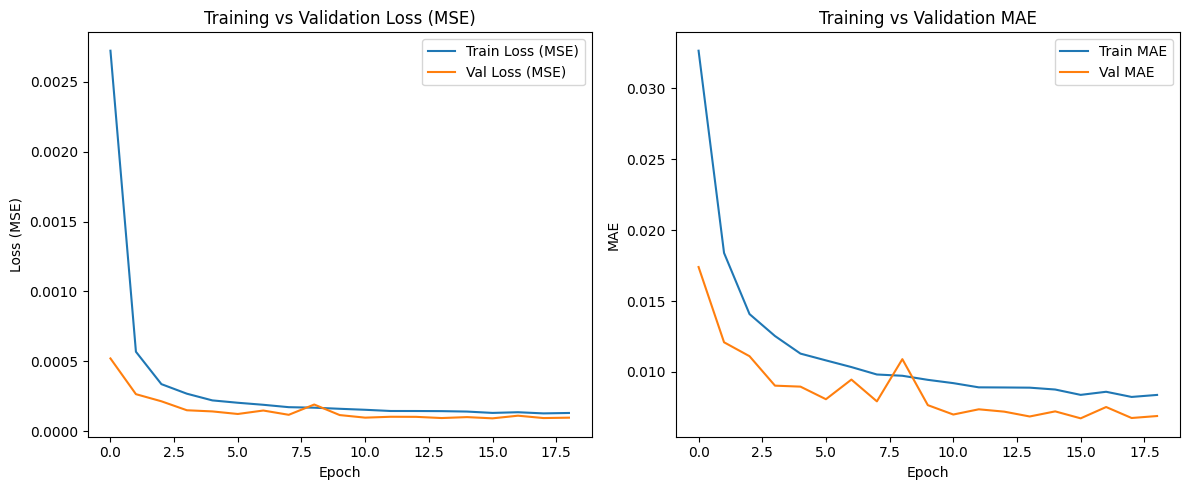

In [36]:
plot_training_history(history)

In [37]:
results = evaluate_model(model, X_test_seq, y_test_seq, scaler_y)
print(results)

219/219 [==============================] - 3s 8ms/step
{'MAE': 0.38754952608823, 'RMSE': 0.5476522647810718, 'MSE': 0.29992300311983716, 'R2 Score': 0.9950161928977328}


Setelah dihypertune:

- **Training loss dan MAE menurun drastis** pada **epoch awal (0–2)** dan mencapai **nilai yang lebih rendah**, menandakan model lebih cepat belajar dari model baseline
- Setelah itu, **kedua metrik mencapai plateau pada level yang lebih rendah dari baseline** loss sekiar 0.00009 dan MAE sekitar 0.0067 dengan **gap antara training dan validation yang sangat kecil**, artinya **resiko overfitting semakin kecil**.  
- **Validation loss dan MAE sangat stabil**, sepanjang sisa epoch menunujukan model **generalizable**.  
- **Fluktuasi minor di beberapa epoch awal** (misal epoch 3–5) untuk data time series sekarang **lebih terkontrol** berkat penyetelan learning rate, dropout, dan unit LSTM dari hasil tuning parameter


## Kita coba gunakan Birectional LSTM

In [38]:
# Bidirectional LSTM model(sama seperti baseline awal tapi kita tambahkan birectional)
model_bi = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(24, 17)),
    LSTM(32),
    Dense(1)
])

model_bi.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_bi.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 128)          41984     
 l)                                                              
                                                                 
 lstm_35 (LSTM)              (None, 32)                20608     
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 62,625
Trainable params: 62,625
Non-trainable params: 0
_________________________________________________________________


 Bidirectional LSTM membaca urutan data dari **masa lalu ke masa sekarang** dan dari **masa depan ke masa sekarang**

## Train Model Birectional Baseline

In [39]:
history_bi = model_bi.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
767/767 [==============================] - 27s 26ms/step - loss: 0.0016 - mae: 0.0219 - val_loss: 2.5367e-04 - val_mae: 0.0119
Epoch 2/20
767/767 [==============================] - 18s 24ms/step - loss: 2.2900e-04 - mae: 0.0112 - val_loss: 1.9171e-04 - val_mae: 0.0103
Epoch 3/20
767/767 [==============================] - 18s 24ms/step - loss: 1.7302e-04 - mae: 0.0097 - val_loss: 1.3362e-04 - val_mae: 0.0083
Epoch 4/20
767/767 [==============================] - 19s 24ms/step - loss: 1.4934e-04 - mae: 0.0090 - val_loss: 1.8147e-04 - val_mae: 0.0101
Epoch 5/20
767/767 [==============================] - 18s 24ms/step - loss: 1.4275e-04 - mae: 0.0088 - val_loss: 1.2878e-04 - val_mae: 0.0084
Epoch 6/20
767/767 [==============================] - 19s 24ms/step - loss: 1.3220e-04 - mae: 0.0084 - val_loss: 1.0771e-04 - val_mae: 0.0075
Epoch 7/20
767/767 [==============================] - 18s 24ms/step - loss: 1.3123e-04 - mae: 0.0084 - val_loss: 1.1143e-04 - val_mae: 0.0076
Epoch 8/20

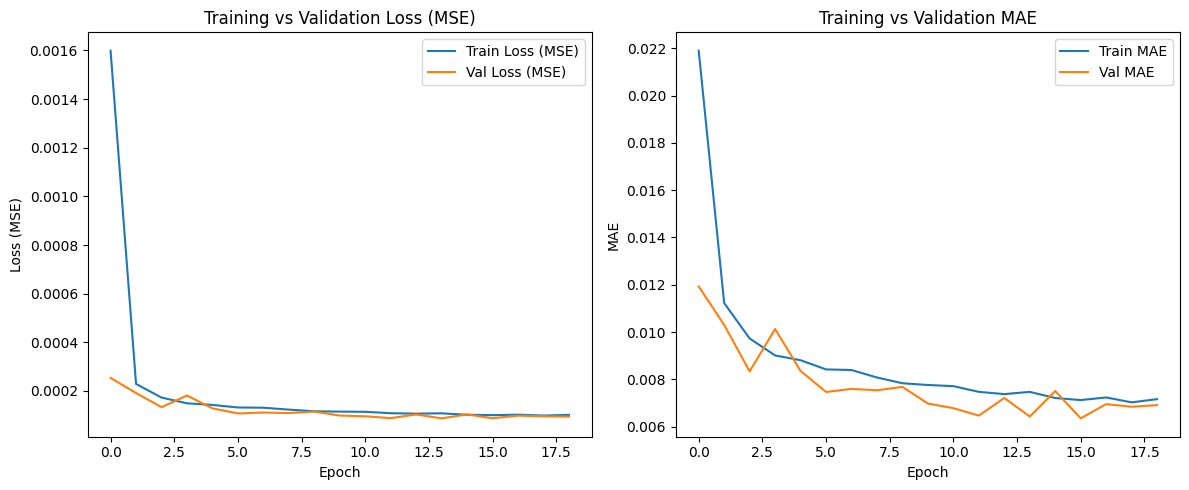

In [40]:
plot_training_history(history_bi)

Pada **baseline Bidirectional LSTM**:

- **Training loss dan MAE menurun cepat** pada **epoch awal (0–2)**, artnya model langsung menangkap pola harian.  
- Setelah itu, **loss dan MAE mencapai plateau** pada level yang **sangat rendah** dengan loss sekitar 0.0001 dan MAE sekitar 0.007 dan **tidak banyak berubah** hingga akhir.  
- **Gap antara training dan validation tetap minimal**, mengonfirmasi bahwa **overfitting terkontrol** meski model lebih kompleks.  
- **Fluktuasi minor** di validation MAE pada beberapa epoch (misal epoch 3–4) masih wajar untuk data time series.  
- **Performa keseluruhan mirip atau sedikit lebih baik** dibanding unidirectional baseline, dengan **validation MAE** yang tetap berada **di bawah 0.01 °C**.  

In [41]:
results_bi = evaluate_model(model_bi, X_test_seq, y_test_seq, scaler_y)
print("Bidirectional Model Results:", results_bi)

219/219 [==============================] - 4s 9ms/step
Bidirectional Model Results: {'MAE': 0.38038394521232716, 'RMSE': 0.5429090410251317, 'MSE': 0.2947502268268281, 'R2 Score': 0.9951021486895839}


- **MAE → 0.38 °C**  
  Rata-rata selisih prediksi hanya 0.38 °C, sedikit lebih baik dibanding unidirectional.

- **RMSE → 0.54 °C**  
  Menunjukkan distribusi error serupa , dengan beberapa outlier kecil.

- **MSE → 0.295 (°C²)**  
  Nilai MSE hampir sama, mengonfirmasi kestabilan performa.

- **R² Score → 0.9951**  
  Menjelaskan 99.51% variansi data, sama saja dengan baseline unidirectional.  


## Hypertuning Birectional Model

In [42]:
def build_bidirectional_lstm_model(units_1, units_2, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Bidirectional(LSTM(units_1, return_sequences=True), input_shape=(24, 17)))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(units_2)))
    model.add(Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Hyperparameter grid
param_grid = {
    'units_1':      [64, 128],
    'units_2':      [32, 64],
    'dropout_rate': [0.1, 0.2],
    'learning_rate':[0.001, 0.0005],
}

results_bi = []

In [43]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 24, 128)           74752     
                                                                 
 dropout_15 (Dropout)        (None, 24, 128)           0         
                                                                 
 lstm_33 (LSTM)              (None, 64)                49408     
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 124,225
Trainable params: 124,225
Non-trainable params: 0
_________________________________________________________________


In [46]:
for u1 in param_grid['units_1']:
    for u2 in param_grid['units_2']:
        for dr in param_grid['dropout_rate']:
            for lr in param_grid['learning_rate']:
                    print(f"Training Bidirectional: units_1={u1}, units_2={u2}, dropout={dr}, lr={lr}, batch_size={bs}")
                    model_bi = build_bidirectional_lstm_model(u1, u2, dr, lr)
                    history_bi = model_bi.fit(
                        X_train_seq, y_train_seq,
                        validation_data=(X_val_seq, y_val_seq),
                        epochs=20,
                        batch_size=bs,
                        verbose=1,
                        callbacks=[
                            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                        ]
                    )
                    val_loss, val_mae = model_bi.evaluate(X_val_seq, y_val_seq, verbose=0)
                    results_bi.append({
                        'units_1': u1,
                        'units_2': u2,
                        'dropout_rate': dr,
                        'learning_rate': lr,
                        'batch_size': bs,
                        'val_loss': val_loss,
                        'val_mae': val_mae
                    })


Training Bidirectional: units_1=64, units_2=32, dropout=0.1, lr=0.001, batch_size=64
Epoch 1/20
767/767 [==============================] - 34s 35ms/step - loss: 0.0031 - mae: 0.0304 - val_loss: 4.3488e-04 - val_mae: 0.0160
Epoch 2/20
767/767 [==============================] - 24s 32ms/step - loss: 4.2351e-04 - mae: 0.0159 - val_loss: 2.2128e-04 - val_mae: 0.0111
Epoch 3/20
767/767 [==============================] - 24s 31ms/step - loss: 3.0582e-04 - mae: 0.0134 - val_loss: 1.9208e-04 - val_mae: 0.0102
Epoch 4/20
767/767 [==============================] - 26s 34ms/step - loss: 2.7105e-04 - mae: 0.0126 - val_loss: 1.7144e-04 - val_mae: 0.0095
Epoch 5/20
767/767 [==============================] - 24s 32ms/step - loss: 2.3908e-04 - mae: 0.0117 - val_loss: 1.6150e-04 - val_mae: 0.0092
Epoch 6/20
767/767 [==============================] - 24s 32ms/step - loss: 2.1923e-04 - mae: 0.0112 - val_loss: 1.4380e-04 - val_mae: 0.0087
Epoch 7/20
767/767 [==============================] - 24s 32ms/step

In [47]:
# Simpan hasil ke DataFrame
results_df_2 = pd.DataFrame(results_bi).sort_values(by='val_loss')

In [48]:
print(results_df_2)

    units_1  units_2  dropout_rate  learning_rate  batch_size  val_loss  \
9       128       32           0.1         0.0005          64  0.000087   
4        64       64           0.1         0.0010          64  0.000089   
10      128       32           0.2         0.0010          64  0.000089   
13      128       64           0.1         0.0005          64  0.000090   
14      128       64           0.2         0.0010          64  0.000090   
3        64       32           0.2         0.0005          64  0.000091   
0        64       32           0.1         0.0010          64  0.000093   
1        64       32           0.1         0.0005          64  0.000093   
6        64       64           0.2         0.0010          64  0.000093   
12      128       64           0.1         0.0010          64  0.000094   
15      128       64           0.2         0.0005          64  0.000095   
8       128       32           0.1         0.0010          64  0.000097   
5        64       64     

In [49]:
best_config = results_df_2.iloc[0]
print("Best Hyperparameters:")
print(best_config)

Best Hyperparameters:
units_1          128.000000
units_2           32.000000
dropout_rate       0.100000
learning_rate      0.000500
batch_size        64.000000
val_loss           0.000087
val_mae            0.006434
Name: 9, dtype: float64


Parameter terbaik yang ditemukan memiliki arsitektur **128 → 32**, dengan **learning rate = 0.0005** dan **dropout = 0.1**.


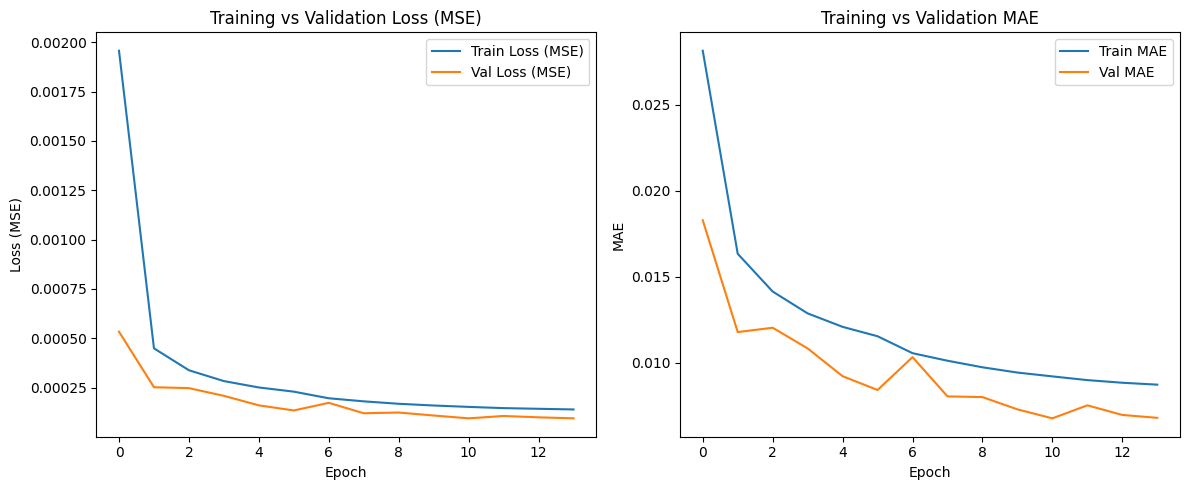

In [50]:
plot_training_history(history_bi)

Pada **baseline Bidirectional LSTM**:

- **Training loss dan MAE menurun cepat** pada **epoch awal (0–2)**, sama seperti tadi model langsung menangkap pola harian 
- Selain itu, **loss (~0.0001) dan MAE (~0.007)** mencapai **plateau** pada level yang **sangat rendah** dan **stabil** hingga akhir.  
- **Gap antara training dan validation sangat kecil**, menegaskan bahwa **overfitting terkendali** meski menjadi model lebih kompleks.  
- **Fluktuasi minor di validation MAE** pada beberapa epoch (misal epoch 3–4) masih wajar untuk data time series.  
- **Performa keseluruhan sedikit lebih baik** dibanding unidirectional baseline, dengan **validation MAE** yang tetap **< 0.01 °C**.  


In [51]:
results_bi = evaluate_model(model, X_test_seq, y_test_seq, scaler_y)
print(results_bi)

219/219 [==============================] - 1s 6ms/step
{'MAE': 0.38754952608823, 'RMSE': 0.5476522647810718, 'MSE': 0.29992300311983716, 'R2 Score': 0.9950161928977328}


- **MAE → 0.388 °C**  
  Rata-rata selisih prediksi sekitar 0.388 °C, performa sangat presisi.

- **RMSE → 0.548 °C**  
  Error kuadrat rata-rata sedikit lebih tinggi (0.548 °C), artinya beberapa prediksi outlier tetapi masih di bawah 1 °C.

- **MSE → 0.300 (°C²)**  
  Konfirmasi bahwa distribusi error relatif sempit dan terkendali.

- **R² Score → 0.9950**  
  Model menjelaskan 99.50% variansi data, menegaskan kemampuan generalisasi yang sangat baik.

**Kesimpulan**  
Kedua model—Unidirectional dan Bidirectional LSTM—menunjukkan **performansi nyaris identik**, oleh karena itu karena uni sangat cepat, pakai saja LSTM uni:)))


In [1]:
import itertools

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Asumsikan sudah ada X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled

all_params = list(itertools.product(
    param_grid['units_1'],
    param_grid['units_2'],
    param_grid['dropout_rate'],
    param_grid['learning_rate']
))

results = []
for (u1, u2, dr, lr) in all_params:
    print(f"Training: units_1={u1}, units_2={u2}, dropout={dr}, lr={lr}")
    model = build_lstm_model(u1, u2, dr, lr)
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=30, batch_size=bs, verbose=0
    )
    y_pred_scaled = model.predict(X_val_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_val_scaled)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    results.append({'units_1': u1, 'units_2': u2, 'dropout': dr, 'lr': lr,
                   'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2})

results = sorted(results, key=lambda x: x['MAE'])
print(results[:3]) # top 3 model


NameError: name 'param_grid' is not defined